In [94]:
import pandas as pd
import numpy as np
from src.scripts import timeseries_anim
import json
from src.scripts.clinical_trials import (
    combine_trials_json,
    plot_clinical_counts,
    classify_disease,
    load_clinical_trials_data,
)

In [95]:
df = pd.read_csv(
    "../data/BindingDB_All.tsv",
    sep="\t",
    usecols=[
        "Ligand SMILES",
        "UniProt (SwissProt) Primary ID of Target Chain",
        "DrugBank ID of Ligand",
        "IC50 (nM)",
        "Article DOI",
        "Institution",
        "Patent Number",
        "ZINC ID of Ligand",
    ],
)

/var/folders/my/2hxsh9b90b9brv55p9f5x2700000gn/T/ipykernel_52484/2446788585.py:1: DtypeWarning:

Columns (9,17,21,23,33,36) have mixed types. Specify dtype option on import or set low_memory=False.



In [96]:
# load initial data
uniprot_ids = [
    "P07949",
    "P14416",
]  # ["P03367", "P37238"]  # TODO: find RET and other interestig ones
targets = timeseries_anim.filter_RET(df, uniprot_ids=uniprot_ids)

In [116]:
uniprot_ids_names_mapping = {"P07949": "RET", "P14416": "D(2) dopamine receptor"}

In [97]:
targets = targets.drop_duplicates(subset=["Ligand SMILES"])

In [98]:
targets

,Ligand SMILES,IC50 (nM),Article DOI,Patent Number,Institution,DrugBank ID of Ligand,ZINC ID of Ligand,UniProt (SwissProt) Primary ID of Target Chain
38708,CSc1ccccc1N1CCN(CCCCCC(=O)NC2CCCc3ccccc23)CC1,NaN,10.1021/jm070487n,NaN,Universita degli Studi di Bari,NaN,ZINC13586566,P14416
38709,COc1ccccc1N1CCN(CCCCCC(=O)NC2CCCc3ccccc23)CC1,NaN,10.1021/jm070487n,NaN,Universita degli Studi di Bari,NaN,ZINC13586534,P14416
38710,Cc1ccccc1N1CCN(CCCCCC(=O)NC2CCCc3ccccc23)CC1,NaN,10.1021/jm070487n,NaN,Universita degli Studi di Bari,NaN,ZINC13586576,P14416
38711,CC(=O)c1ccccc1N1CCN(CCCCCC(=O)NC2CCCc3ccccc23)CC1,NaN,10.1021/jm070487n,NaN,Universita degli Studi di Bari,NaN,ZINC13586546,P14416
38712,Oc1ccccc1N1CCN(CCCCCC(=O)NC2CCCc3ccccc23)CC1,NaN,10.1021/jm070487n,NaN,Universita degli Studi di Bari,NaN,ZINC13586570,P14416
...,...,...,...,...,...,...,...,...
2914186,Cn1cc(C(=O)NC23CC4CC(CC(C4)C2)C3)c(Nc2ccc(Oc3c...,11,NaN,NaN,NaN,NaN,NaN,P07949
2914187,Cn1cc(C(=O)NC23CC4CC(CC(C4)C2)C3)c(Nc2ccc(Oc3c...,12,NaN,NaN,NaN,NaN,NaN,P07949
2914601,Cc1cc(nc(Nc2ccccc2-c2nnn[nH]2)n1)C(F)(F)F,NaN,NaN,NaN,NaN,NaN,NaN,P14416
2916514,OCc1cc(Oc2ccc3c(cccc3c2)C(=O)Nc2cccc(c2)C(F)(F...,30,NaN,NaN,NaN,NaN,NaN,P07949


In [99]:
targets

,Ligand SMILES,IC50 (nM),Article DOI,Patent Number,Institution,DrugBank ID of Ligand,ZINC ID of Ligand,UniProt (SwissProt) Primary ID of Target Chain
38708,CSc1ccccc1N1CCN(CCCCCC(=O)NC2CCCc3ccccc23)CC1,NaN,10.1021/jm070487n,NaN,Universita degli Studi di Bari,NaN,ZINC13586566,P14416
38709,COc1ccccc1N1CCN(CCCCCC(=O)NC2CCCc3ccccc23)CC1,NaN,10.1021/jm070487n,NaN,Universita degli Studi di Bari,NaN,ZINC13586534,P14416
38710,Cc1ccccc1N1CCN(CCCCCC(=O)NC2CCCc3ccccc23)CC1,NaN,10.1021/jm070487n,NaN,Universita degli Studi di Bari,NaN,ZINC13586576,P14416
38711,CC(=O)c1ccccc1N1CCN(CCCCCC(=O)NC2CCCc3ccccc23)CC1,NaN,10.1021/jm070487n,NaN,Universita degli Studi di Bari,NaN,ZINC13586546,P14416
38712,Oc1ccccc1N1CCN(CCCCCC(=O)NC2CCCc3ccccc23)CC1,NaN,10.1021/jm070487n,NaN,Universita degli Studi di Bari,NaN,ZINC13586570,P14416
...,...,...,...,...,...,...,...,...
2914186,Cn1cc(C(=O)NC23CC4CC(CC(C4)C2)C3)c(Nc2ccc(Oc3c...,11,NaN,NaN,NaN,NaN,NaN,P07949
2914187,Cn1cc(C(=O)NC23CC4CC(CC(C4)C2)C3)c(Nc2ccc(Oc3c...,12,NaN,NaN,NaN,NaN,NaN,P07949
2914601,Cc1cc(nc(Nc2ccccc2-c2nnn[nH]2)n1)C(F)(F)F,NaN,NaN,NaN,NaN,NaN,NaN,P14416
2916514,OCc1cc(Oc2ccc3c(cccc3c2)C(=O)Nc2cccc(c2)C(F)(F...,30,NaN,NaN,NaN,NaN,NaN,P07949


In [100]:
# citations
with open("../src/data/citations.json", "r") as f:
    citations = json.load(f)
citations = pd.DataFrame(citations)

# merge
targets = (
    pd.merge(
        left=targets,
        right=citations,
        left_on="Article DOI",
        right_on="doi",
        how="outer",
    )
    .dropna(subset="Ligand SMILES")
    .drop(columns="Article DOI")
)

In [101]:
targets

,Ligand SMILES,IC50 (nM),Patent Number,Institution,DrugBank ID of Ligand,ZINC ID of Ligand,UniProt (SwissProt) Primary ID of Target Chain,doi,citation
1,Nc1ccccc1C(=O)NCCCCN1CCN(CC1)c1nsc2ccccc12,NaN,NaN,University of Toronto,NaN,ZINC01537573,P14416,10.1002/(SICI)1098-2396(199702)25:2,NaN
2,NCCc1c[nH]c2ccc(O)cc12,NaN,NaN,University of Toronto,NaN,ZINC00057058,P14416,10.1002/(SICI)1098-2396(199702)25:2,NaN
3,[NH3+][C@@H]1CCc2cc(O)c(O)cc2C1,NaN,NaN,University of Toronto,NaN,ZINC03872369,P14416,10.1002/(SICI)1098-2396(199702)25:2,NaN
4,NCC(O)c1ccc(O)c(O)c1,NaN,NaN,University of Toronto,NaN,ZINC00057624,P14416,10.1002/(SICI)1098-2396(199702)25:2,NaN
5,CN1C[C@H](CSc2ccccn2)C[C@@H]2Cc3c(O)cccc3C[C@@...,NaN,NaN,University of Toronto,NaN,ZINC03826945,P14416,10.1002/(SICI)1098-2396(199702)25:2,NaN
...,...,...,...,...,...,...,...,...,...
54806,Cn1cc(C(=O)NC23CC4CC(CC(C4)C2)C3)c(Nc2ccc(Oc3c...,11,NaN,NaN,NaN,NaN,P07949,NaN,NaN
54807,Cn1cc(C(=O)NC23CC4CC(CC(C4)C2)C3)c(Nc2ccc(Oc3c...,12,NaN,NaN,NaN,NaN,P07949,NaN,NaN
54808,Cc1cc(nc(Nc2ccccc2-c2nnn[nH]2)n1)C(F)(F)F,NaN,NaN,NaN,NaN,NaN,P14416,NaN,NaN
54809,OCc1cc(Oc2ccc3c(cccc3c2)C(=O)Nc2cccc(c2)C(F)(F...,30,NaN,NaN,NaN,NaN,P07949,NaN,NaN


In [102]:
# patents
with open("../src/data/patents.json", "r") as f:
    patents = json.load(f)
patents_df = pd.DataFrame(
    [
        {
            "patent": patent["patent"],
            "patent_status": patent["info"].get("status", np.nan),
            "families citing": int(patent["info"].get("families citing", 0) or 0),
            "cited by": int(patent["info"].get("cited by", 0) or 0),
        }
        for patent in patents
        if isinstance(patent, dict) and isinstance(patent.get("info"), dict)
    ]
)
patents_df["patent_citations"] = patents_df["families citing"] + patents_df["cited by"]
patents_df.drop(columns=["families citing", "cited by"], inplace=True)

# merge
targets = (
    pd.merge(
        left=targets,
        right=patents_df,
        left_on="Patent Number",
        right_on="patent",
        how="outer",
    )
    .dropna(subset="Ligand SMILES")
    .drop(columns="Patent Number")
)

In [103]:
targets

,Ligand SMILES,IC50 (nM),Institution,DrugBank ID of Ligand,ZINC ID of Ligand,UniProt (SwissProt) Primary ID of Target Chain,doi,citation,patent,patent_status,patent_citations
54,Cn1cc(cn1)-c1cc(-c2ccc(nc2)N2CCN(CC2)C(=O)OC(C...,35.8,Array BioPharma Inc,NaN,NaN,P07949,NaN,NaN,US10023570,Active,76.0
55,Cn1cc(cn1)-c1cc(-c2ccc(nc2)N2CCNCC2)c2c(cnn2c1...,19.6,Array BioPharma Inc,NaN,NaN,P07949,NaN,NaN,US10023570,Active,76.0
56,Cn1cc(cn1)-c1cc(-c2ccc(nc2)N2CCN(CC2)C(=O)CCS(...,11.9,Array BioPharma Inc,NaN,NaN,P07949,NaN,NaN,US10023570,Active,76.0
57,Cn1cc(cn1)-c1cc(-c2ccc(nc2)N2CCN(CC2)C(=O)[C@@...,3.10,Array BioPharma Inc,NaN,NaN,P07949,NaN,NaN,US10023570,Active,76.0
58,Cn1cc(cn1)-c1cc(-c2ccc(nc2)N2CCN(CC2)C(=O)Cc2c...,4.60,Array BioPharma Inc,NaN,NaN,P07949,NaN,NaN,US10023570,Active,76.0
...,...,...,...,...,...,...,...,...,...,...,...
22148,Cn1cc(C(=O)NC23CC4CC(CC(C4)C2)C3)c(Nc2ccc(Oc3c...,11,NaN,NaN,NaN,P07949,NaN,NaN,NaN,NaN,NaN
22149,Cn1cc(C(=O)NC23CC4CC(CC(C4)C2)C3)c(Nc2ccc(Oc3c...,12,NaN,NaN,NaN,P07949,NaN,NaN,NaN,NaN,NaN
22150,Cc1cc(nc(Nc2ccccc2-c2nnn[nH]2)n1)C(F)(F)F,NaN,NaN,NaN,NaN,P14416,NaN,NaN,NaN,NaN,NaN
22151,OCc1cc(Oc2ccc3c(cccc3c2)C(=O)Nc2cccc(c2)C(F)(F...,30,NaN,NaN,NaN,P07949,NaN,NaN,NaN,NaN,NaN


In [104]:
# TODO: clinical trials: check clinical_trials.ipynb and understand how to get the graphs
# count data into the current df (by merging on ZINC IDs, which are already in 'targets')
paths = [
    "../src/data/ZINC_references_trials_amel.json",
    "../src/data/ZINC_references_trials_daphne.json",
    "../src/data/ZINC_references_trials_wes.json",
    "../src/data/ZINC_references_trials_greg.json",
    "../src/data/ZINC_references_trials_guillaume.json",
]
df_all = combine_trials_json(paths)
df_all

,ZINC ID of Ligand,code,description,status_name,phase_name,start_date
0,ZINC03814434,NCT03114228,An Expanded Treatment Protocol (ETP) of Midost...,No longer available,None,None
1,ZINC03814434,NCT02624570,Midostaurin Access Program for Newly Diagnosed...,Available,None,None
2,ZINC03814434,NCT03258931,Study of Crenolanib vs Midostaurin Following I...,Not yet recruiting,Phase 3,2018-05-01
3,ZINC03814434,NCT03207334,iCare4: Genomic Signatures With Midostaurin in...,Not yet recruiting,Phase 2,2018-05-01
4,ZINC03814434,NCT03092674,Azacitidine With or Without Nivolumab or Midos...,Recruiting,Phase 2/Phase 3,2017-12-22
...,...,...,...,...,...,...
340574,ZINC00056568,NCT00004871,Azacitidine Plus Phenylbutyrate in Treating Pa...,Completed,Phase 1,2000-05-01
340575,ZINC00056568,NCT00002796,Phase I-II Study of Fluorouracil in Combinatio...,Terminated,Phase 1/Phase 2,1997-05-01
340576,ZINC00056568,NCT00002909,Phenylbutyrate in Treating Patients With Refra...,Completed,Phase 1,1997-02-01
340577,ZINC00056568,NCT00001565,Phase I and Pharmacokinetic Trial of Phenylbut...,Completed,Phase 1,1996-12-01


In [105]:
phase_4_count_df = (
    df_all.query("status_name == 'Completed'")
    .value_counts(["ZINC ID of Ligand", "phase_name"])
    .reset_index()
    .query("phase_name == 'Phase 4'")
    .rename(columns={"count": "phase_4_count"})
    .drop(columns="phase_name")
)

In [106]:
targets

,Ligand SMILES,IC50 (nM),Institution,DrugBank ID of Ligand,ZINC ID of Ligand,UniProt (SwissProt) Primary ID of Target Chain,doi,citation,patent,patent_status,patent_citations
54,Cn1cc(cn1)-c1cc(-c2ccc(nc2)N2CCN(CC2)C(=O)OC(C...,35.8,Array BioPharma Inc,NaN,NaN,P07949,NaN,NaN,US10023570,Active,76.0
55,Cn1cc(cn1)-c1cc(-c2ccc(nc2)N2CCNCC2)c2c(cnn2c1...,19.6,Array BioPharma Inc,NaN,NaN,P07949,NaN,NaN,US10023570,Active,76.0
56,Cn1cc(cn1)-c1cc(-c2ccc(nc2)N2CCN(CC2)C(=O)CCS(...,11.9,Array BioPharma Inc,NaN,NaN,P07949,NaN,NaN,US10023570,Active,76.0
57,Cn1cc(cn1)-c1cc(-c2ccc(nc2)N2CCN(CC2)C(=O)[C@@...,3.10,Array BioPharma Inc,NaN,NaN,P07949,NaN,NaN,US10023570,Active,76.0
58,Cn1cc(cn1)-c1cc(-c2ccc(nc2)N2CCN(CC2)C(=O)Cc2c...,4.60,Array BioPharma Inc,NaN,NaN,P07949,NaN,NaN,US10023570,Active,76.0
...,...,...,...,...,...,...,...,...,...,...,...
22148,Cn1cc(C(=O)NC23CC4CC(CC(C4)C2)C3)c(Nc2ccc(Oc3c...,11,NaN,NaN,NaN,P07949,NaN,NaN,NaN,NaN,NaN
22149,Cn1cc(C(=O)NC23CC4CC(CC(C4)C2)C3)c(Nc2ccc(Oc3c...,12,NaN,NaN,NaN,P07949,NaN,NaN,NaN,NaN,NaN
22150,Cc1cc(nc(Nc2ccccc2-c2nnn[nH]2)n1)C(F)(F)F,NaN,NaN,NaN,NaN,P14416,NaN,NaN,NaN,NaN,NaN
22151,OCc1cc(Oc2ccc3c(cccc3c2)C(=O)Nc2cccc(c2)C(F)(F...,30,NaN,NaN,NaN,P07949,NaN,NaN,NaN,NaN,NaN


In [107]:
# merge
targets = pd.merge(
    left=targets,
    right=phase_4_count_df,
    left_on="ZINC ID of Ligand",
    right_on="ZINC ID of Ligand",
    how="outer",
).dropna(subset="Ligand SMILES")

In [108]:
targets

,Ligand SMILES,IC50 (nM),Institution,DrugBank ID of Ligand,ZINC ID of Ligand,UniProt (SwissProt) Primary ID of Target Chain,doi,citation,patent,patent_status,patent_citations,phase_4_count
2,COc1ccc2C[C@@H]3N(C)CCc4cc5OCOc5c(c34)-c2c1O,NaN,Neuroscience Research Centre,NaN,ZINC00000103,P14416,NaN,NaN,NaN,NaN,NaN,NaN
4,Cl.CN1CCN2C(C1)c1ccccc1Cc1ccccc21,NaN,Johnson & Johnson Pharmaceutical Research & De...,NaN,ZINC00000504,P14416,10.1021/jm049632c,64.0,NaN,NaN,NaN,40.0
10,CN1CCN2[C@H](C1)c1ccccc1Cc1ccccc21,NaN,Oregon Health Sciences University,NaN,ZINC00000855,P14416,10.1073/pnas.86.24.9762,316.0,NaN,NaN,NaN,NaN
11,CN[C@@H](C)Cc1ccc2OCOc2c1,NaN,SRI International,NaN,ZINC00000859,P14416,NaN,NaN,NaN,NaN,NaN,NaN
14,Clc1ccc2Oc3ccccc3N=C(N3CCNCC3)c2c1,NaN,University of Toronto,DB00543,ZINC00000931,P14416,10.1038/sj.mp.4000336,215.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
15433,Cn1cc(C(=O)NC23CC4CC(CC(C4)C2)C3)c(Nc2ccc(Oc3c...,11,NaN,NaN,NaN,P07949,NaN,NaN,NaN,NaN,NaN,NaN
15434,Cn1cc(C(=O)NC23CC4CC(CC(C4)C2)C3)c(Nc2ccc(Oc3c...,12,NaN,NaN,NaN,P07949,NaN,NaN,NaN,NaN,NaN,NaN
15435,Cc1cc(nc(Nc2ccccc2-c2nnn[nH]2)n1)C(F)(F)F,NaN,NaN,NaN,NaN,P14416,NaN,NaN,NaN,NaN,NaN,NaN
15436,OCc1cc(Oc2ccc3c(cccc3c2)C(=O)Nc2cccc(c2)C(F)(F...,30,NaN,NaN,NaN,P07949,NaN,NaN,NaN,NaN,NaN,NaN


In [109]:
# clean IC50
targets.replace(" NV,", np.nan, inplace=True)
targets["IC50 (nM)"] = targets["IC50 (nM)"].astype(str).str.replace(" C", "")
targets["IC50 (nM)"] = (
    targets["IC50 (nM)"]
    .astype(str)
    .str.replace(">", "")
    .str.replace("<", "")
    .astype(float)
)
targets["log(IC50+1) (nM)"] = (targets["IC50 (nM)"] + 1).apply(np.log10)
# targets.drop(columns="IC50 (nM)", inplace=True)

In [110]:
# fingerprints
targets = timeseries_anim.get_ligands_fingerprint(targets)

[14:52:59] Explicit valence for atom # 1 N, 4, is greater than permitted
[14:53:00] Explicit valence for atom # 35 N, 4, is greater than permitted
[14:53:00] Explicit valence for atom # 11 N, 4, is greater than permitted
[14:53:01] Explicit valence for atom # 1 N, 4, is greater than permitted
[14:53:02] Explicit valence for atom # 17 N, 4, is greater than permitted
[14:53:02] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 25 26 27
[14:53:02] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28
[14:53:02] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27 28 29 30 31
[14:53:02] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28 29 30 31 32
[14:53:02] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27 28 29 30 31
[14:53:03] Explicit valence for atom # 32 O, 3, is greater than permitted
[14:53:03] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25
[14:53:03] Explicit valence for atom # 1 N, 4, is greater than permitted
[14:53:04] Can't 

In [111]:
# pca applied to each target seperately
store = []
for target in targets["UniProt (SwissProt) Primary ID of Target Chain"].unique():
    temp = targets[
        targets["UniProt (SwissProt) Primary ID of Target Chain"] == target
    ].copy()
    temp, _, _ = timeseries_anim.PCA_fingerprints(temp)
    store.append(temp)
result = pd.concat(store, ignore_index=True)

## final data has info for pca overlayed with:
# - ic50
# - citations (article)
# - patent citations
result

,Ligand SMILES,IC50 (nM),Institution,DrugBank ID of Ligand,ZINC ID of Ligand,UniProt (SwissProt) Primary ID of Target Chain,doi,citation,patent,patent_status,patent_citations,phase_4_count,log(IC50+1) (nM),Ligand Fingerprint,PC1,PC2,PC3
0,COc1ccc2C[C@@H]3N(C)CCc4cc5OCOc5c(c34)-c2c1O,NaN,Neuroscience Research Centre,NaN,ZINC00000103,P14416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-0.388546,0.627447,-0.917382
1,Cl.CN1CCN2C(C1)c1ccccc1Cc1ccccc21,NaN,Johnson & Johnson Pharmaceutical Research & De...,NaN,ZINC00000504,P14416,10.1021/jm049632c,64.0,NaN,NaN,NaN,40.0,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",0.859371,-0.477471,-0.967223
2,CN1CCN2[C@H](C1)c1ccccc1Cc1ccccc21,NaN,Oregon Health Sciences University,NaN,ZINC00000855,P14416,10.1073/pnas.86.24.9762,316.0,NaN,NaN,NaN,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",0.861891,-0.469440,-0.923098
3,CN[C@@H](C)Cc1ccc2OCOc2c1,NaN,SRI International,NaN,ZINC00000859,P14416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.159838,0.396381,-1.348808
4,Clc1ccc2Oc3ccccc3N=C(N3CCNCC3)c2c1,NaN,University of Toronto,DB00543,ZINC00000931,P14416,10.1038/sj.mp.4000336,215.0,NaN,NaN,NaN,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.152295,-2.323527,-1.663577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14909,COc1cc2nccc(Oc3ccc(Nc4nn(C)cc4C(=O)NC45CC6CC(C...,136.0,NaN,NaN,NaN,P07949,NaN,NaN,NaN,NaN,NaN,NaN,2.136721,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-6.104999,-4.110644,7.080907
14910,Cn1cc(C(=O)NC23CC4CC(CC(C4)C2)C3)c(Nc2ccc(Oc3c...,11.0,NaN,NaN,NaN,P07949,NaN,NaN,NaN,NaN,NaN,NaN,1.079181,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",-8.223888,-6.251151,9.498203
14911,Cn1cc(C(=O)NC23CC4CC(CC(C4)C2)C3)c(Nc2ccc(Oc3c...,12.0,NaN,NaN,NaN,P07949,NaN,NaN,NaN,NaN,NaN,NaN,1.113943,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",-8.790191,-6.480956,12.567789
14912,OCc1cc(Oc2ccc3c(cccc3c2)C(=O)Nc2cccc(c2)C(F)(F...,30.0,NaN,NaN,NaN,P07949,NaN,NaN,NaN,NaN,NaN,NaN,1.491362,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-7.125589,-1.855761,1.536736


In [112]:
result = result.drop_duplicates(subset=["Ligand SMILES"])

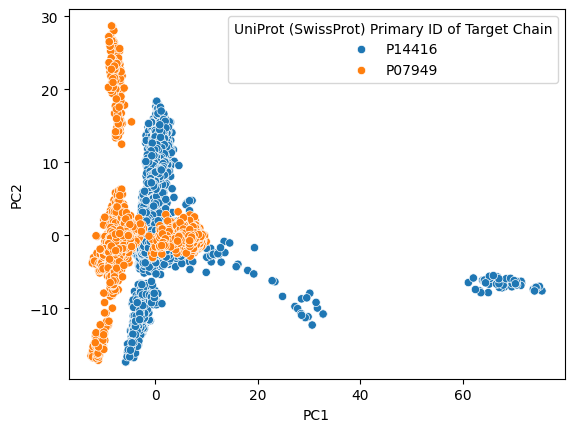

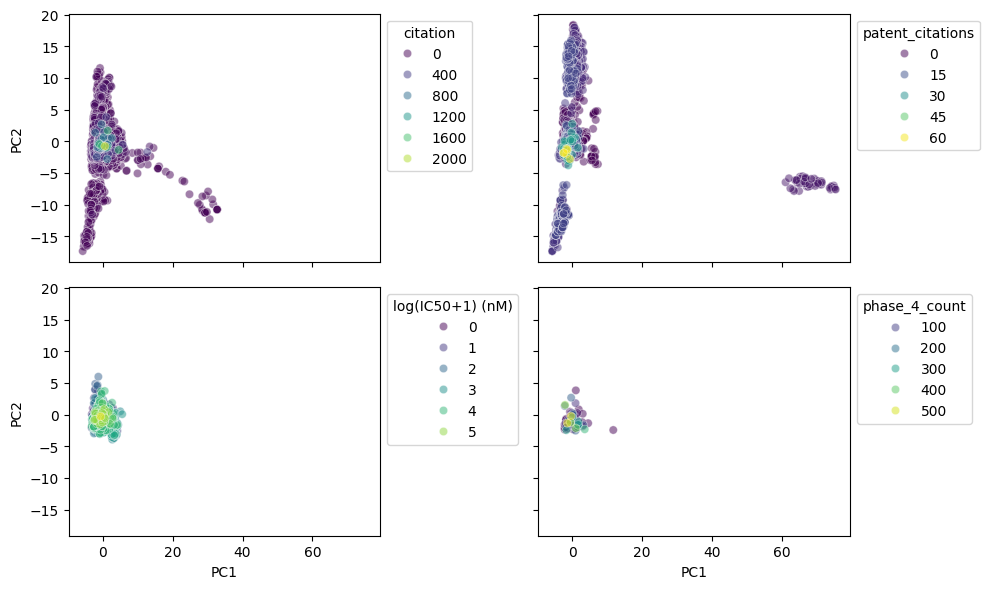

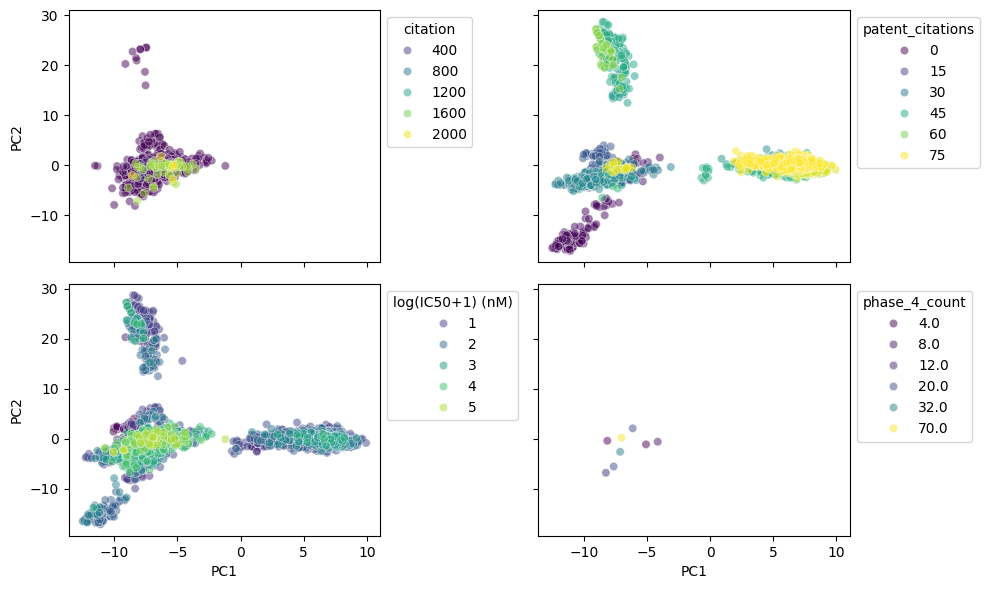

In [113]:
# examples:
import seaborn as sns
from matplotlib import pyplot as plt

# pcas of each target
sns.scatterplot(
    result, x="PC1", y="PC2", hue="UniProt (SwissProt) Primary ID of Target Chain"
)
plt.show()

# seperating each pca and overlaying stuff
# TODO: plotly
for target in targets["UniProt (SwissProt) Primary ID of Target Chain"].unique():
    fig, axs = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(10, 6))
    for ax, hue in zip(
        axs.flatten(),
        ["citation", "patent_citations", "log(IC50+1) (nM)", "phase_4_count"],
    ):
        sns.scatterplot(
            result[
                result["UniProt (SwissProt) Primary ID of Target Chain"] == target
            ].sort_values(hue),
            x="PC1",
            y="PC2",
            hue=hue,
            ax=ax,
            palette="viridis",
            alpha=0.5,
        )
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

In [120]:
uniprot_ids_names_mapping

{'P07949': 'RET', 'P14416': 'D(2) dopamine receptor'}

In [130]:
import plotly.graph_objects as go
from src.scripts.save_plotly import save_plotly

for target in targets["UniProt (SwissProt) Primary ID of Target Chain"].unique():
    result_ = result[result["UniProt (SwissProt) Primary ID of Target Chain"] == target]

    # Compute the global x and y ranges based on the full dataset
    x_range = [1.1 * result_["PC1"].min(), 1.1 * result_["PC1"].max()]
    y_range = [1.1 * result_["PC2"].min(), 1.1 * result_["PC2"].max()]

    # Create a base figure
    fig = go.Figure()

    # List of hue variables
    hue_variables = [
        "citation",
        "patent_citations",
        "log(IC50+1) (nM)",
        "phase_4_count",
    ]
    title = f"{uniprot_ids_names_mapping[target]} Ligand Fingerprint PC1 vs PC2"

    # Loop through each hue variable, filter out NaN values, and add as a separate trace
    for hue in hue_variables:
        filtered_data = result_.dropna(subset=[hue]).sort_values(
            hue
        )  # Drop rows where hue has NaN
        fig.add_trace(
            go.Scatter(
                x=filtered_data["PC1"],
                y=filtered_data["PC2"],
                mode="markers",
                marker=dict(
                    size=8,
                    color=filtered_data[hue],
                    colorscale="Viridis",
                    showscale=True,
                    # opacity=0.5,
                    colorbar=dict(
                        title=hue.capitalize().replace("_", " ")
                    ),  # Custom colorbar title
                ),
                name=hue,  # Name will be used in the dropdown menu
                visible=False,  # Initially hidden; we will toggle visibility
                # hoverinfo=hue,
            )
        )

    # Set the first trace to be visible initially
    fig.data[0].visible = True

    # Create dropdown menu
    dropdown_buttons = [
        dict(
            label=hue.capitalize().replace("_", " "),
            method="update",
            args=[
                {
                    "visible": [i == idx for i in range(len(hue_variables))]
                },  # Toggle visibility
                {
                    "title": f"{title} with {hue.capitalize().replace('_', ' ')} overlayed"
                },  # Update title dynamically
            ],
        )
        for idx, hue in enumerate(hue_variables)
    ]

    # Add dropdown menu and set consistent x and y ranges in layout
    fig.update_layout(
        updatemenus=[
            dict(
                buttons=dropdown_buttons,
                direction="down",
                showactive=True,
                # x=0.1,  # Position of the dropdown menu
                # y=1.15,
            )
        ],
        title={
            "text": title,
            "x": 0.5,
            "xanchor": "center",
            "yanchor": "top",
        },
        xaxis=dict(title="PC1", range=x_range),  # Fixed x-axis range
        yaxis=dict(title="PC2", range=y_range),  # Fixed y-axis range
        template="plotly_dark",
    )

    save_plotly(
        fig,
        f"../frontend/figures/{uniprot_ids_names_mapping[target].replace(' ', '_')}_2D_PCA_overlays",
    )

    # Show the figure
    fig.show()

In [131]:
result

,Ligand SMILES,IC50 (nM),Institution,DrugBank ID of Ligand,ZINC ID of Ligand,UniProt (SwissProt) Primary ID of Target Chain,doi,citation,patent,patent_status,patent_citations,phase_4_count,log(IC50+1) (nM),Ligand Fingerprint,PC1,PC2,PC3
0,COc1ccc2C[C@@H]3N(C)CCc4cc5OCOc5c(c34)-c2c1O,NaN,Neuroscience Research Centre,NaN,ZINC00000103,P14416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-0.388546,0.627447,-0.917382
1,Cl.CN1CCN2C(C1)c1ccccc1Cc1ccccc21,NaN,Johnson & Johnson Pharmaceutical Research & De...,NaN,ZINC00000504,P14416,10.1021/jm049632c,64.0,NaN,NaN,NaN,40.0,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",0.859371,-0.477471,-0.967223
2,CN1CCN2[C@H](C1)c1ccccc1Cc1ccccc21,NaN,Oregon Health Sciences University,NaN,ZINC00000855,P14416,10.1073/pnas.86.24.9762,316.0,NaN,NaN,NaN,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",0.861891,-0.469440,-0.923098
3,CN[C@@H](C)Cc1ccc2OCOc2c1,NaN,SRI International,NaN,ZINC00000859,P14416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.159838,0.396381,-1.348808
4,Clc1ccc2Oc3ccccc3N=C(N3CCNCC3)c2c1,NaN,University of Toronto,DB00543,ZINC00000931,P14416,10.1038/sj.mp.4000336,215.0,NaN,NaN,NaN,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.152295,-2.323527,-1.663577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14909,COc1cc2nccc(Oc3ccc(Nc4nn(C)cc4C(=O)NC45CC6CC(C...,136.0,NaN,NaN,NaN,P07949,NaN,NaN,NaN,NaN,NaN,NaN,2.136721,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-6.104999,-4.110644,7.080907
14910,Cn1cc(C(=O)NC23CC4CC(CC(C4)C2)C3)c(Nc2ccc(Oc3c...,11.0,NaN,NaN,NaN,P07949,NaN,NaN,NaN,NaN,NaN,NaN,1.079181,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",-8.223888,-6.251151,9.498203
14911,Cn1cc(C(=O)NC23CC4CC(CC(C4)C2)C3)c(Nc2ccc(Oc3c...,12.0,NaN,NaN,NaN,P07949,NaN,NaN,NaN,NaN,NaN,NaN,1.113943,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",-8.790191,-6.480956,12.567789
14912,OCc1cc(Oc2ccc3c(cccc3c2)C(=O)Nc2cccc(c2)C(F)(F...,30.0,NaN,NaN,NaN,P07949,NaN,NaN,NaN,NaN,NaN,NaN,1.491362,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-7.125589,-1.855761,1.536736


In [132]:
result_ = result[result["UniProt (SwissProt) Primary ID of Target Chain"] == "P14416"]

In [133]:
result_

,Ligand SMILES,IC50 (nM),Institution,DrugBank ID of Ligand,ZINC ID of Ligand,UniProt (SwissProt) Primary ID of Target Chain,doi,citation,patent,patent_status,patent_citations,phase_4_count,log(IC50+1) (nM),Ligand Fingerprint,PC1,PC2,PC3
0,COc1ccc2C[C@@H]3N(C)CCc4cc5OCOc5c(c34)-c2c1O,NaN,Neuroscience Research Centre,NaN,ZINC00000103,P14416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-0.388546,0.627447,-0.917382
1,Cl.CN1CCN2C(C1)c1ccccc1Cc1ccccc21,NaN,Johnson & Johnson Pharmaceutical Research & De...,NaN,ZINC00000504,P14416,10.1021/jm049632c,64.0,NaN,NaN,NaN,40.0,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",0.859371,-0.477471,-0.967223
2,CN1CCN2[C@H](C1)c1ccccc1Cc1ccccc21,NaN,Oregon Health Sciences University,NaN,ZINC00000855,P14416,10.1073/pnas.86.24.9762,316.0,NaN,NaN,NaN,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",0.861891,-0.469440,-0.923098
3,CN[C@@H](C)Cc1ccc2OCOc2c1,NaN,SRI International,NaN,ZINC00000859,P14416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.159838,0.396381,-1.348808
4,Clc1ccc2Oc3ccccc3N=C(N3CCNCC3)c2c1,NaN,University of Toronto,DB00543,ZINC00000931,P14416,10.1038/sj.mp.4000336,215.0,NaN,NaN,NaN,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.152295,-2.323527,-1.663577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10405,CCCN(CCc1cc(O)c(CCN(CCC)[C@H]2CCc3nc(N)sc3C2)c...,NaN,NaN,NaN,NaN,P14416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.084675,0.671844,0.991798
10406,CCCN(CCc1ccc(CCN(CCC)[C@H]2CCc3c(O)cccc3C2)cc1...,NaN,NaN,NaN,NaN,P14416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-0.082101,-2.393105,-1.190585
10407,Fc1ccc(CN2CCCC22CCN(Cc3cc4ccc(Cl)cc4[nH]3)C2)cc1F,NaN,NaN,NaN,NaN,P14416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2.134945,-2.973326,-0.036137
10408,Fc1ccc(CN2CCCC3(CCN(Cc4cc5ccc(Cl)cc5[nH]4)C3)C...,NaN,NaN,NaN,NaN,P14416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2.157374,-2.118559,-0.075070


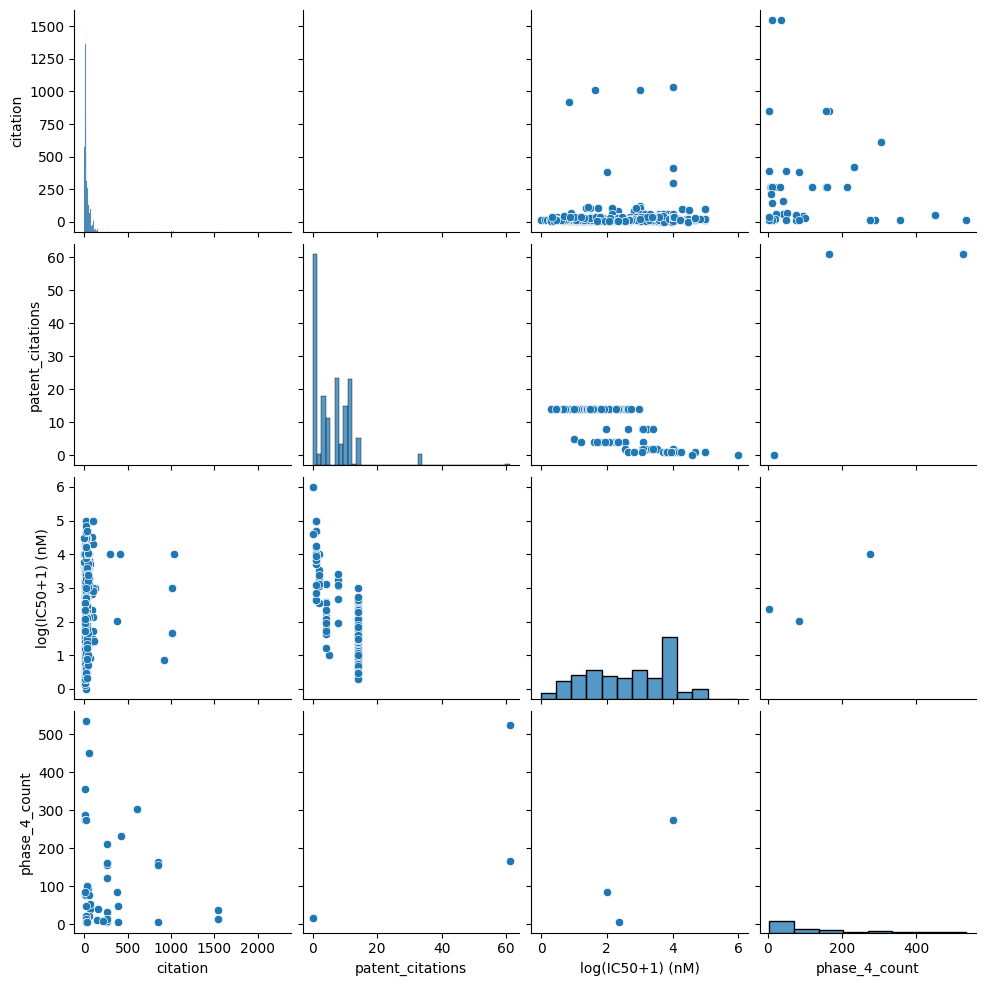

In [134]:
sns.pairplot(
    result_[["citation", "patent_citations", "log(IC50+1) (nM)", "phase_4_count"]]
)